#### Disclaimer: For variational autoencoders, I applied the code at:
https://www.kaggle.com/habibizadkhah/variational-autoencoder-chest-xray-pneumonia-m1
#### For dcgan, I made refernce to the following page
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

## 1. input data and cleaning

### 1.1. Import Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
import random
# to ignore displaying warnings
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D,Input,UpSampling2D, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda, Conv2DTranspose, Layer, LeakyReLU
from tensorflow.keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
import tensorflow.keras.backend as K
import tensorflow as tf

### 1.2. Load the Dataset

In [2]:
def load_images(dir_path, labels, dsize = (32, 32)):
    """loading images"""
    X_image, y_image = [], []
    for label_name, Id in labels.items():
        for jpeg in tqdm(os.listdir(os.path.join(dir_path, label_name))):
            path = os.path.join(dir_path, label_name, jpeg)
            image = load_img(path, target_size=dsize)
            X_image.append(image)
            #self.X_image.append(img_to_array(image)/255.0)
            y_image.append(Id)
    return X_image, y_image

def display_images(X, y, figure_row=4, figure_cols=4):
    """Display images """
    f, ax = plt.subplots(nrows= figure_row, ncols=figure_cols, 
                         figsize=(figure_row*figure_cols, figure_row*figure_cols)) 
    number_of_images = figure_row * figure_cols
    img = []
    for i in range(figure_row):
        for j in range(figure_cols):
            while True:
                rand = np.random.randint(0, len(X)-1)
                if rand not in img:
                    img.append(rand)
                    break
            image=X[rand]#cv2.imread(self.path_lsts[rand])
            ax[i, j].imshow(image, resample=True, cmap='gray')
            ax[i, j].set_title("Class-"+ str(y[rand]), fontsize=16)
    plt.tight_layout()
    plt.show()
    print

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 84.09it/s]


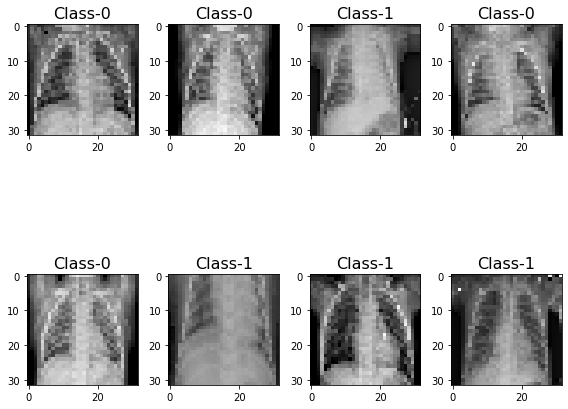

In [3]:
dsize =(32, 32)
labels = {"NORMAL":0, "PNEUMONIA":1}

train_path = "./chest_xray/train"
test_path = "./chest_xray/test"
val_path = "./chest_xray/val"

X_train_org, y_train = load_images(train_path, labels, dsize = dsize)
X_test_org, y_test = load_images(test_path, labels, dsize = dsize)
X_val_org, y_val = load_images(val_path, labels, dsize = dsize)
display_images(X_train_org, y_train, figure_row=2, figure_cols=4)

### 1.3. Preprocessing Images

In [4]:
# regularization and shuffle
def preprocess_images(images, y, normalize = True):
    X = []
    for i in tqdm(range(len(images))):
        img = img_to_array(images[i]).astype('float32')
        if normalize:
            img = img/255.0
        X.append(img)
    #Shuffle data
    dataset = list(zip(X, y))
    random.shuffle(dataset)

    X, y = zip(*dataset)
    return np.array(X), np.array(y)

normalize = True
X_train, y_train =preprocess_images(X_train_org, y_train, normalize=normalize)
print("Shape of X_train:", X_train.shape)
X_val, y_val =preprocess_images(X_val_org, y_val, normalize=normalize)
print("Shape of X_val:", X_val.shape)
X_test, y_test =preprocess_images(X_test_org, y_test, normalize=normalize)
print("Shape of X_test:", X_test.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 624/624 [00:00<00:00, 16449.59it/s]


Shape of X_train: (5216, 32, 32, 3)
Shape of X_val: (16, 32, 32, 3)
Shape of X_test: (624, 32, 32, 3)


## 2. Deep Convolutional Generative Adversarial Network

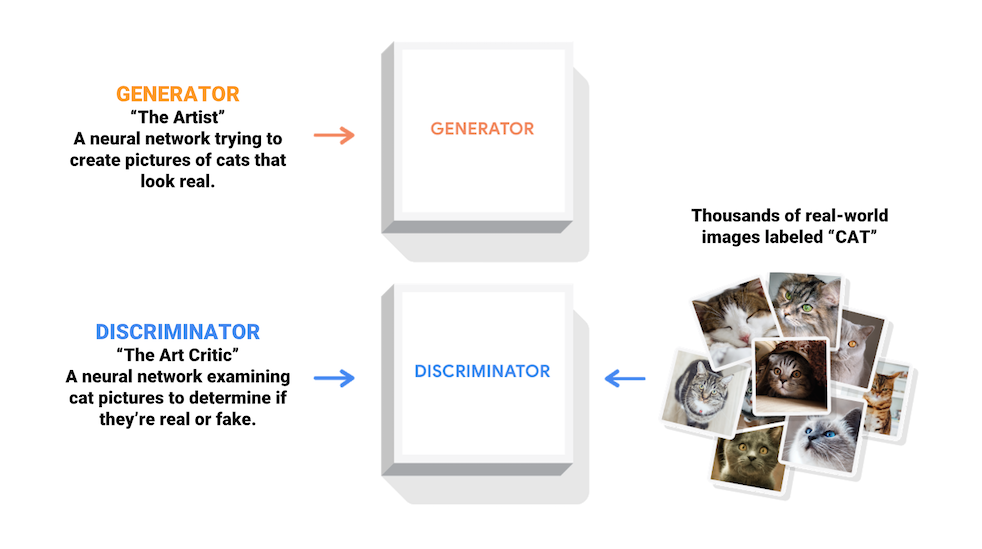

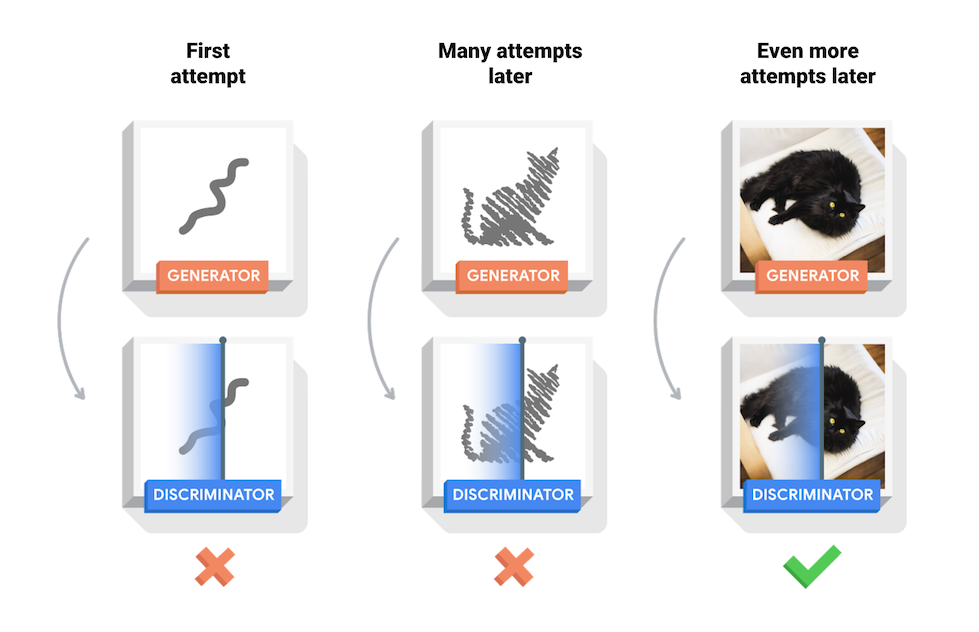

### 3.1. Import the necessary libraries

In [5]:
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import plot_model

### 3.2. Build and train the discriminator model

Discriminator

In [6]:
def define_discriminator(in_shape = (32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [7]:
model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

Load training samples

In [8]:
X_train, y_train =preprocess_images(X_train_org, y_train, normalize=normalize)
print("Shape of X_train:", X_train.shape)
X_val, y_val =preprocess_images(X_val_org, y_val, normalize=normalize)
print("Shape of X_val:", X_val.shape)
X_test, y_test =preprocess_images(X_test_org, y_test, normalize=normalize)
print("Shape of X_test:", X_test.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 624/624 [00:00<00:00, 17364.84it/s]

Shape of X_train: (5216, 32, 32, 3)
Shape of X_val: (16, 32, 32, 3)
Shape of X_test: (624, 32, 32, 3)


In [ ]:
# resize the shape of our data
# data_X_dg = [cv2.resize(X_train[i], (32, 32), interpolation = cv2.INTER_AREA) for i in range(X_train.shape[0])]
# data_X_dg = np.array(data_X_dg)

Select real samples

In [15]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    
    return X, y

Select fake samples, random pixel values 

In [10]:
def generate_fake_samples(n_samples):
    X = rand(32 * 32 * 3 * n_samples)
    X = -1 + X * 2
    X = X.reshape((n_samples, 32, 32, 3))
    y = zeros((n_samples, 1))
    
    return X, y

Train the discriminator model

In [11]:
def train_discriminator(model, dataset, n_iter = 20, n_batch = 128):
    half_batch = int(n_batch / 2)
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [12]:
train_discriminator(model, X_train)

>1 real=95% fake=0%
>2 real=100% fake=61%
>3 real=100% fake=100%
>4 real=100% fake=100%
>5 real=100% fake=100%
>6 real=100% fake=100%
>7 real=100% fake=100%
>8 real=100% fake=100%
>9 real=100% fake=100%
>10 real=100% fake=100%
>11 real=100% fake=100%
>12 real=100% fake=100%
>13 real=100% fake=100%
>14 real=100% fake=100%
>15 real=100% fake=100%
>16 real=100% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


### 3.2. Build and train the generator model

In [13]:
from numpy import zeros
from numpy.random import randn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from matplotlib import pyplot

def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    
    return model

# initialize input for the latent space
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# initialize input for the generator
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    
    return X, y

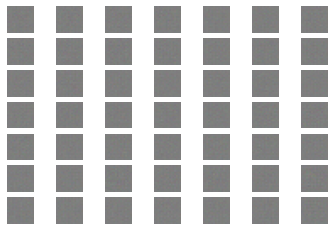

In [14]:
# size of the latent space
latent_dim = 100
model = define_generator(latent_dim)
# generate samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
X = (X + 1) / 2.0
for i in range(n_samples):
    pyplot.subplot(7, 7, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i])
pyplot.show()

In [16]:
model.summary()
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)        

### 3.2. Build and train the composition model

In [23]:
# demonstrate creating the three models in the gan
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
 
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [18]:
def train_gan(gan_model, latent_dim, n_epochs = 200, n_batch = 128):
    for i in range(n_epochs):
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)

def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

Train the generator and the discriminator

In [19]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    real_loss, fake_loss, generator_loss = [ ], [ ], [ ]
    # manually enumerate epochs
    for i in range(n_epochs):
		# enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # add up all loss functions
            real_loss.append(d_loss1)
            fake_loss.append(d_loss2)
            generator_loss.append(g_loss)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
    
    return real_loss, fake_loss, generator_loss

In [26]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# train model
real_loss, fake_loss, generator_loss = train(g_model, d_model, gan_model, X_train, latent_dim)

>1, 1/40, d1=0.710, d2=0.694 g=0.693
>1, 2/40, d1=0.639, d2=0.696 g=0.691
>1, 3/40, d1=0.564, d2=0.700 g=0.687
>1, 4/40, d1=0.466, d2=0.713 g=0.674
>1, 5/40, d1=0.340, d2=0.747 g=0.643
>1, 6/40, d1=0.217, d2=0.828 g=0.584
>1, 7/40, d1=0.143, d2=0.977 g=0.514
>1, 8/40, d1=0.119, d2=1.141 g=0.474
>1, 9/40, d1=0.175, d2=1.201 g=0.490
>1, 10/40, d1=0.275, d2=1.120 g=0.541
>1, 11/40, d1=0.391, d2=0.968 g=0.623
>1, 12/40, d1=0.494, d2=0.833 g=0.718
>1, 13/40, d1=0.567, d2=0.720 g=0.807
>1, 14/40, d1=0.602, d2=0.647 g=0.882
>1, 15/40, d1=0.616, d2=0.584 g=0.941
>1, 16/40, d1=0.610, d2=0.547 g=0.999
>1, 17/40, d1=0.615, d2=0.551 g=0.980
>1, 18/40, d1=0.590, d2=0.604 g=0.891
>1, 19/40, d1=0.534, d2=0.662 g=0.802
>1, 20/40, d1=0.512, d2=0.713 g=0.726
>1, 21/40, d1=0.421, d2=0.750 g=0.680
>1, 22/40, d1=0.357, d2=0.798 g=0.645
>1, 23/40, d1=0.290, d2=0.854 g=0.613
>1, 24/40, d1=0.249, d2=0.912 g=0.585
>1, 25/40, d1=0.252, d2=0.984 g=0.553
>1, 26/40, d1=0.248, d2=1.000 g=0.553
>1, 27/40, d1=0.276, 

>6, 19/40, d1=0.632, d2=0.817 g=0.643
>6, 20/40, d1=0.641, d2=0.812 g=0.651
>6, 21/40, d1=0.635, d2=0.790 g=0.679
>6, 22/40, d1=0.654, d2=0.750 g=0.704
>6, 23/40, d1=0.666, d2=0.737 g=0.724
>6, 24/40, d1=0.680, d2=0.715 g=0.738
>6, 25/40, d1=0.683, d2=0.681 g=0.766
>6, 26/40, d1=0.697, d2=0.658 g=0.794
>6, 27/40, d1=0.697, d2=0.638 g=0.818
>6, 28/40, d1=0.709, d2=0.621 g=0.840
>6, 29/40, d1=0.705, d2=0.611 g=0.855
>6, 30/40, d1=0.720, d2=0.607 g=0.856
>6, 31/40, d1=0.714, d2=0.610 g=0.853
>6, 32/40, d1=0.712, d2=0.632 g=0.819
>6, 33/40, d1=0.698, d2=0.641 g=0.807
>6, 34/40, d1=0.681, d2=0.646 g=0.785
>6, 35/40, d1=0.684, d2=0.666 g=0.777
>6, 36/40, d1=0.666, d2=0.665 g=0.772
>6, 37/40, d1=0.640, d2=0.684 g=0.749
>6, 38/40, d1=0.646, d2=0.698 g=0.730
>6, 39/40, d1=0.639, d2=0.717 g=0.725
>6, 40/40, d1=0.631, d2=0.730 g=0.716
>7, 1/40, d1=0.642, d2=0.731 g=0.701
>7, 2/40, d1=0.631, d2=0.740 g=0.698
>7, 3/40, d1=0.639, d2=0.763 g=0.690
>7, 4/40, d1=0.615, d2=0.764 g=0.685
>7, 5/40, d1=0.6

>11, 34/40, d1=0.655, d2=0.677 g=0.775
>11, 35/40, d1=0.645, d2=0.676 g=0.767
>11, 36/40, d1=0.627, d2=0.681 g=0.780
>11, 37/40, d1=0.649, d2=0.673 g=0.774
>11, 38/40, d1=0.668, d2=0.687 g=0.755
>11, 39/40, d1=0.652, d2=0.687 g=0.771
>11, 40/40, d1=0.664, d2=0.710 g=0.756
>12, 1/40, d1=0.691, d2=0.694 g=0.744
>12, 2/40, d1=0.708, d2=0.709 g=0.755
>12, 3/40, d1=0.705, d2=0.708 g=0.758
>12, 4/40, d1=0.711, d2=0.676 g=0.756
>12, 5/40, d1=0.702, d2=0.676 g=0.765
>12, 6/40, d1=0.708, d2=0.659 g=0.767
>12, 7/40, d1=0.688, d2=0.669 g=0.766
>12, 8/40, d1=0.692, d2=0.668 g=0.763
>12, 9/40, d1=0.670, d2=0.664 g=0.773
>12, 10/40, d1=0.675, d2=0.668 g=0.766
>12, 11/40, d1=0.658, d2=0.672 g=0.759
>12, 12/40, d1=0.660, d2=0.676 g=0.758
>12, 13/40, d1=0.674, d2=0.675 g=0.761
>12, 14/40, d1=0.665, d2=0.684 g=0.756
>12, 15/40, d1=0.636, d2=0.675 g=0.767
>12, 16/40, d1=0.660, d2=0.664 g=0.783
>12, 17/40, d1=0.641, d2=0.658 g=0.797
>12, 18/40, d1=0.646, d2=0.646 g=0.801
>12, 19/40, d1=0.620, d2=0.643 g=0

>17, 6/40, d1=0.632, d2=0.616 g=0.890
>17, 7/40, d1=0.609, d2=0.619 g=0.850
>17, 8/40, d1=0.596, d2=0.650 g=0.851
>17, 9/40, d1=0.595, d2=0.669 g=0.809
>17, 10/40, d1=0.606, d2=0.687 g=0.808
>17, 11/40, d1=0.588, d2=0.741 g=0.765
>17, 12/40, d1=0.631, d2=0.738 g=0.737
>17, 13/40, d1=0.613, d2=0.745 g=0.754
>17, 14/40, d1=0.599, d2=0.778 g=0.762
>17, 15/40, d1=0.678, d2=0.757 g=0.755
>17, 16/40, d1=0.636, d2=0.758 g=0.752
>17, 17/40, d1=0.639, d2=0.764 g=0.782
>17, 18/40, d1=0.658, d2=0.688 g=0.804
>17, 19/40, d1=0.673, d2=0.680 g=0.816
>17, 20/40, d1=0.695, d2=0.669 g=0.819
>17, 21/40, d1=0.670, d2=0.654 g=0.823
>17, 22/40, d1=0.655, d2=0.647 g=0.827
>17, 23/40, d1=0.660, d2=0.654 g=0.821
>17, 24/40, d1=0.638, d2=0.680 g=0.792
>17, 25/40, d1=0.645, d2=0.710 g=0.760
>17, 26/40, d1=0.637, d2=0.722 g=0.742
>17, 27/40, d1=0.619, d2=0.728 g=0.735
>17, 28/40, d1=0.637, d2=0.772 g=0.748
>17, 29/40, d1=0.625, d2=0.743 g=0.748
>17, 30/40, d1=0.637, d2=0.741 g=0.749
>17, 31/40, d1=0.647, d2=0.71

>22, 17/40, d1=0.651, d2=0.669 g=0.790
>22, 18/40, d1=0.668, d2=0.724 g=0.761
>22, 19/40, d1=0.632, d2=0.716 g=0.764
>22, 20/40, d1=0.635, d2=0.735 g=0.742
>22, 21/40, d1=0.651, d2=0.731 g=0.741
>22, 22/40, d1=0.660, d2=0.745 g=0.767
>22, 23/40, d1=0.660, d2=0.724 g=0.769
>22, 24/40, d1=0.632, d2=0.704 g=0.768
>22, 25/40, d1=0.644, d2=0.760 g=0.756
>22, 26/40, d1=0.646, d2=0.682 g=0.751
>22, 27/40, d1=0.675, d2=0.698 g=0.788
>22, 28/40, d1=0.650, d2=0.710 g=0.779
>22, 29/40, d1=0.654, d2=0.676 g=0.788
>22, 30/40, d1=0.673, d2=0.698 g=0.775
>22, 31/40, d1=0.674, d2=0.651 g=0.809
>22, 32/40, d1=0.653, d2=0.668 g=0.794
>22, 33/40, d1=0.670, d2=0.654 g=0.777
>22, 34/40, d1=0.652, d2=0.672 g=0.778
>22, 35/40, d1=0.652, d2=0.663 g=0.771
>22, 36/40, d1=0.643, d2=0.695 g=0.737
>22, 37/40, d1=0.633, d2=0.765 g=0.727
>22, 38/40, d1=0.638, d2=0.748 g=0.721
>22, 39/40, d1=0.655, d2=0.721 g=0.749
>22, 40/40, d1=0.660, d2=0.723 g=0.744
>23, 1/40, d1=0.667, d2=0.683 g=0.754
>23, 2/40, d1=0.646, d2=0.

>27, 29/40, d1=0.652, d2=0.694 g=0.755
>27, 30/40, d1=0.638, d2=0.707 g=0.753
>27, 31/40, d1=0.656, d2=0.698 g=0.737
>27, 32/40, d1=0.663, d2=0.722 g=0.725
>27, 33/40, d1=0.663, d2=0.721 g=0.722
>27, 34/40, d1=0.653, d2=0.722 g=0.720
>27, 35/40, d1=0.685, d2=0.735 g=0.737
>27, 36/40, d1=0.658, d2=0.730 g=0.744
>27, 37/40, d1=0.681, d2=0.687 g=0.764
>27, 38/40, d1=0.691, d2=0.706 g=0.771
>27, 39/40, d1=0.689, d2=0.677 g=0.783
>27, 40/40, d1=0.691, d2=0.648 g=0.794
>28, 1/40, d1=0.707, d2=0.643 g=0.790
>28, 2/40, d1=0.700, d2=0.661 g=0.805
>28, 3/40, d1=0.707, d2=0.656 g=0.804
>28, 4/40, d1=0.700, d2=0.650 g=0.799
>28, 5/40, d1=0.707, d2=0.654 g=0.794
>28, 6/40, d1=0.708, d2=0.658 g=0.782
>28, 7/40, d1=0.702, d2=0.665 g=0.775
>28, 8/40, d1=0.693, d2=0.696 g=0.755
>28, 9/40, d1=0.701, d2=0.670 g=0.754
>28, 10/40, d1=0.686, d2=0.701 g=0.758
>28, 11/40, d1=0.695, d2=0.688 g=0.784
>28, 12/40, d1=0.711, d2=0.664 g=0.795
>28, 13/40, d1=0.697, d2=0.651 g=0.798
>28, 14/40, d1=0.709, d2=0.654 g=0

>32, 40/40, d1=0.665, d2=0.684 g=0.745
>33, 1/40, d1=0.665, d2=0.681 g=0.746
>33, 2/40, d1=0.647, d2=0.678 g=0.743
>33, 3/40, d1=0.665, d2=0.695 g=0.731
>33, 4/40, d1=0.666, d2=0.681 g=0.733
>33, 5/40, d1=0.656, d2=0.700 g=0.736
>33, 6/40, d1=0.667, d2=0.694 g=0.733
>33, 7/40, d1=0.662, d2=0.703 g=0.730
>33, 8/40, d1=0.682, d2=0.691 g=0.722
>33, 9/40, d1=0.665, d2=0.718 g=0.731
>33, 10/40, d1=0.678, d2=0.697 g=0.718
>33, 11/40, d1=0.690, d2=0.709 g=0.721
>33, 12/40, d1=0.666, d2=0.720 g=0.718
>33, 13/40, d1=0.677, d2=0.708 g=0.718
>33, 14/40, d1=0.678, d2=0.712 g=0.731
>33, 15/40, d1=0.683, d2=0.713 g=0.726
>33, 16/40, d1=0.690, d2=0.709 g=0.732
>33, 17/40, d1=0.678, d2=0.706 g=0.728
>33, 18/40, d1=0.684, d2=0.701 g=0.737
>33, 19/40, d1=0.680, d2=0.691 g=0.740
>33, 20/40, d1=0.700, d2=0.684 g=0.756
>33, 21/40, d1=0.704, d2=0.677 g=0.763
>33, 22/40, d1=0.702, d2=0.679 g=0.761
>33, 23/40, d1=0.710, d2=0.678 g=0.762
>33, 24/40, d1=0.703, d2=0.680 g=0.755
>33, 25/40, d1=0.692, d2=0.674 g=0

>38, 12/40, d1=0.687, d2=0.674 g=0.779
>38, 13/40, d1=0.698, d2=0.661 g=0.783
>38, 14/40, d1=0.688, d2=0.668 g=0.773
>38, 15/40, d1=0.689, d2=0.670 g=0.770
>38, 16/40, d1=0.673, d2=0.673 g=0.778
>38, 17/40, d1=0.668, d2=0.674 g=0.767
>38, 18/40, d1=0.683, d2=0.673 g=0.768
>38, 19/40, d1=0.705, d2=0.685 g=0.756
>38, 20/40, d1=0.683, d2=0.700 g=0.750
>38, 21/40, d1=0.692, d2=0.688 g=0.752
>38, 22/40, d1=0.697, d2=0.685 g=0.741
>38, 23/40, d1=0.701, d2=0.695 g=0.737
>38, 24/40, d1=0.695, d2=0.703 g=0.742
>38, 25/40, d1=0.700, d2=0.700 g=0.739
>38, 26/40, d1=0.702, d2=0.693 g=0.741
>38, 27/40, d1=0.690, d2=0.685 g=0.748
>38, 28/40, d1=0.699, d2=0.695 g=0.750
>38, 29/40, d1=0.688, d2=0.680 g=0.758
>38, 30/40, d1=0.705, d2=0.681 g=0.776
>38, 31/40, d1=0.711, d2=0.645 g=0.784
>38, 32/40, d1=0.716, d2=0.644 g=0.786
>38, 33/40, d1=0.719, d2=0.654 g=0.786
>38, 34/40, d1=0.698, d2=0.647 g=0.789
>38, 35/40, d1=0.714, d2=0.649 g=0.784
>38, 36/40, d1=0.694, d2=0.657 g=0.778
>38, 37/40, d1=0.708, d2=

>43, 23/40, d1=0.681, d2=0.671 g=0.765
>43, 24/40, d1=0.656, d2=0.685 g=0.769
>43, 25/40, d1=0.670, d2=0.683 g=0.755
>43, 26/40, d1=0.679, d2=0.697 g=0.755
>43, 27/40, d1=0.672, d2=0.683 g=0.748
>43, 28/40, d1=0.668, d2=0.702 g=0.742
>43, 29/40, d1=0.681, d2=0.675 g=0.752
>43, 30/40, d1=0.679, d2=0.704 g=0.743
>43, 31/40, d1=0.703, d2=0.695 g=0.735
>43, 32/40, d1=0.685, d2=0.686 g=0.739
>43, 33/40, d1=0.681, d2=0.687 g=0.749
>43, 34/40, d1=0.691, d2=0.706 g=0.754
>43, 35/40, d1=0.711, d2=0.678 g=0.747
>43, 36/40, d1=0.689, d2=0.685 g=0.758
>43, 37/40, d1=0.679, d2=0.684 g=0.745
>43, 38/40, d1=0.696, d2=0.694 g=0.740
>43, 39/40, d1=0.690, d2=0.688 g=0.741
>43, 40/40, d1=0.701, d2=0.693 g=0.743
>44, 1/40, d1=0.674, d2=0.699 g=0.747
>44, 2/40, d1=0.699, d2=0.695 g=0.740
>44, 3/40, d1=0.679, d2=0.700 g=0.744
>44, 4/40, d1=0.687, d2=0.694 g=0.759
>44, 5/40, d1=0.671, d2=0.693 g=0.756
>44, 6/40, d1=0.671, d2=0.684 g=0.755
>44, 7/40, d1=0.683, d2=0.678 g=0.747
>44, 8/40, d1=0.679, d2=0.690 g=

>48, 35/40, d1=0.683, d2=0.667 g=0.756
>48, 36/40, d1=0.685, d2=0.673 g=0.758
>48, 37/40, d1=0.688, d2=0.663 g=0.762
>48, 38/40, d1=0.686, d2=0.667 g=0.755
>48, 39/40, d1=0.690, d2=0.679 g=0.755
>48, 40/40, d1=0.686, d2=0.662 g=0.746
>49, 1/40, d1=0.681, d2=0.666 g=0.754
>49, 2/40, d1=0.671, d2=0.674 g=0.747
>49, 3/40, d1=0.683, d2=0.680 g=0.751
>49, 4/40, d1=0.691, d2=0.673 g=0.753
>49, 5/40, d1=0.690, d2=0.674 g=0.748
>49, 6/40, d1=0.661, d2=0.668 g=0.753
>49, 7/40, d1=0.688, d2=0.697 g=0.752
>49, 8/40, d1=0.687, d2=0.695 g=0.741
>49, 9/40, d1=0.689, d2=0.687 g=0.748
>49, 10/40, d1=0.685, d2=0.684 g=0.747
>49, 11/40, d1=0.685, d2=0.682 g=0.760
>49, 12/40, d1=0.692, d2=0.691 g=0.754
>49, 13/40, d1=0.683, d2=0.685 g=0.752
>49, 14/40, d1=0.678, d2=0.677 g=0.767
>49, 15/40, d1=0.696, d2=0.667 g=0.756
>49, 16/40, d1=0.684, d2=0.664 g=0.758
>49, 17/40, d1=0.700, d2=0.681 g=0.751
>49, 18/40, d1=0.697, d2=0.684 g=0.747
>49, 19/40, d1=0.689, d2=0.678 g=0.743
>49, 20/40, d1=0.687, d2=0.687 g=0

>54, 6/40, d1=0.662, d2=0.678 g=0.754
>54, 7/40, d1=0.666, d2=0.683 g=0.747
>54, 8/40, d1=0.653, d2=0.687 g=0.752
>54, 9/40, d1=0.660, d2=0.690 g=0.745
>54, 10/40, d1=0.649, d2=0.684 g=0.739
>54, 11/40, d1=0.653, d2=0.683 g=0.729
>54, 12/40, d1=0.658, d2=0.694 g=0.741
>54, 13/40, d1=0.642, d2=0.698 g=0.736
>54, 14/40, d1=0.670, d2=0.715 g=0.737
>54, 15/40, d1=0.656, d2=0.691 g=0.736
>54, 16/40, d1=0.665, d2=0.700 g=0.735
>54, 17/40, d1=0.685, d2=0.683 g=0.748
>54, 18/40, d1=0.670, d2=0.696 g=0.734
>54, 19/40, d1=0.679, d2=0.694 g=0.745
>54, 20/40, d1=0.664, d2=0.697 g=0.746
>54, 21/40, d1=0.692, d2=0.679 g=0.762
>54, 22/40, d1=0.667, d2=0.670 g=0.772
>54, 23/40, d1=0.688, d2=0.680 g=0.771
>54, 24/40, d1=0.694, d2=0.675 g=0.760
>54, 25/40, d1=0.676, d2=0.666 g=0.758
>54, 26/40, d1=0.687, d2=0.693 g=0.741
>54, 27/40, d1=0.679, d2=0.699 g=0.745
>54, 28/40, d1=0.672, d2=0.696 g=0.737
>54, 29/40, d1=0.683, d2=0.685 g=0.743
>54, 30/40, d1=0.686, d2=0.697 g=0.753
>54, 31/40, d1=0.684, d2=0.68

>59, 18/40, d1=0.692, d2=0.672 g=0.777
>59, 19/40, d1=0.677, d2=0.684 g=0.761
>59, 20/40, d1=0.658, d2=0.672 g=0.762
>59, 21/40, d1=0.668, d2=0.672 g=0.758
>59, 22/40, d1=0.664, d2=0.668 g=0.760
>59, 23/40, d1=0.675, d2=0.684 g=0.764
>59, 24/40, d1=0.683, d2=0.684 g=0.772
>59, 25/40, d1=0.682, d2=0.676 g=0.784
>59, 26/40, d1=0.673, d2=0.649 g=0.781
>59, 27/40, d1=0.674, d2=0.661 g=0.785
>59, 28/40, d1=0.661, d2=0.671 g=0.789
>59, 29/40, d1=0.659, d2=0.646 g=0.818
>59, 30/40, d1=0.681, d2=0.635 g=0.799
>59, 31/40, d1=0.661, d2=0.654 g=0.804
>59, 32/40, d1=0.663, d2=0.654 g=0.799
>59, 33/40, d1=0.654, d2=0.666 g=0.794
>59, 34/40, d1=0.641, d2=0.672 g=0.762
>59, 35/40, d1=0.651, d2=0.691 g=0.742
>59, 36/40, d1=0.611, d2=0.710 g=0.738
>59, 37/40, d1=0.633, d2=0.722 g=0.752
>59, 38/40, d1=0.631, d2=0.704 g=0.751
>59, 39/40, d1=0.649, d2=0.685 g=0.747
>59, 40/40, d1=0.623, d2=0.708 g=0.750
>60, 1/40, d1=0.637, d2=0.696 g=0.765
>60, 2/40, d1=0.644, d2=0.680 g=0.764
>60, 3/40, d1=0.632, d2=0.6

>64, 29/40, d1=0.670, d2=0.669 g=0.786
>64, 30/40, d1=0.696, d2=0.682 g=0.771
>64, 31/40, d1=0.671, d2=0.666 g=0.775
>64, 32/40, d1=0.680, d2=0.668 g=0.773
>64, 33/40, d1=0.697, d2=0.668 g=0.768
>64, 34/40, d1=0.662, d2=0.720 g=0.773
>64, 35/40, d1=0.662, d2=0.690 g=0.789
>64, 36/40, d1=0.682, d2=0.676 g=0.793
>64, 37/40, d1=0.677, d2=0.669 g=0.783
>64, 38/40, d1=0.680, d2=0.661 g=0.782
>64, 39/40, d1=0.699, d2=0.665 g=0.793
>64, 40/40, d1=0.671, d2=0.679 g=0.792
>65, 1/40, d1=0.683, d2=0.673 g=0.829
>65, 2/40, d1=0.691, d2=0.641 g=0.808
>65, 3/40, d1=0.666, d2=0.635 g=0.824
>65, 4/40, d1=0.674, d2=0.644 g=0.831
>65, 5/40, d1=0.704, d2=0.636 g=0.818
>65, 6/40, d1=0.694, d2=0.647 g=0.818
>65, 7/40, d1=0.691, d2=0.635 g=0.788
>65, 8/40, d1=0.639, d2=0.665 g=0.801
>65, 9/40, d1=0.682, d2=0.656 g=0.779
>65, 10/40, d1=0.671, d2=0.698 g=0.788
>65, 11/40, d1=0.658, d2=0.695 g=0.762
>65, 12/40, d1=0.701, d2=0.687 g=0.756
>65, 13/40, d1=0.682, d2=0.692 g=0.752
>65, 14/40, d1=0.683, d2=0.696 g=0

>70, 1/40, d1=0.648, d2=0.701 g=0.757
>70, 2/40, d1=0.658, d2=0.677 g=0.757
>70, 3/40, d1=0.651, d2=0.691 g=0.737
>70, 4/40, d1=0.690, d2=0.735 g=0.748
>70, 5/40, d1=0.637, d2=0.699 g=0.733
>70, 6/40, d1=0.653, d2=0.712 g=0.748
>70, 7/40, d1=0.660, d2=0.681 g=0.753
>70, 8/40, d1=0.619, d2=0.690 g=0.744
>70, 9/40, d1=0.653, d2=0.709 g=0.767
>70, 10/40, d1=0.668, d2=0.679 g=0.791
>70, 11/40, d1=0.648, d2=0.654 g=0.808
>70, 12/40, d1=0.672, d2=0.643 g=0.845
>70, 13/40, d1=0.674, d2=0.649 g=0.801
>70, 14/40, d1=0.657, d2=0.647 g=0.808
>70, 15/40, d1=0.678, d2=0.668 g=0.792
>70, 16/40, d1=0.689, d2=0.674 g=0.794
>70, 17/40, d1=0.688, d2=0.652 g=0.797
>70, 18/40, d1=0.677, d2=0.659 g=0.787
>70, 19/40, d1=0.686, d2=0.673 g=0.790
>70, 20/40, d1=0.672, d2=0.658 g=0.777
>70, 21/40, d1=0.679, d2=0.665 g=0.760
>70, 22/40, d1=0.672, d2=0.678 g=0.760
>70, 23/40, d1=0.677, d2=0.687 g=0.781
>70, 24/40, d1=0.702, d2=0.658 g=0.799
>70, 25/40, d1=0.710, d2=0.683 g=0.807
>70, 26/40, d1=0.687, d2=0.657 g=0

>75, 12/40, d1=0.635, d2=0.634 g=0.836
>75, 13/40, d1=0.683, d2=0.655 g=0.815
>75, 14/40, d1=0.673, d2=0.687 g=0.788
>75, 15/40, d1=0.675, d2=0.654 g=0.789
>75, 16/40, d1=0.686, d2=0.662 g=0.789
>75, 17/40, d1=0.665, d2=0.670 g=0.790
>75, 18/40, d1=0.661, d2=0.673 g=0.790
>75, 19/40, d1=0.651, d2=0.676 g=0.793
>75, 20/40, d1=0.632, d2=0.686 g=0.786
>75, 21/40, d1=0.633, d2=0.665 g=0.818
>75, 22/40, d1=0.657, d2=0.630 g=0.819
>75, 23/40, d1=0.665, d2=0.625 g=0.830
>75, 24/40, d1=0.695, d2=0.647 g=0.821
>75, 25/40, d1=0.677, d2=0.621 g=0.811
>75, 26/40, d1=0.663, d2=0.660 g=0.798
>75, 27/40, d1=0.607, d2=0.672 g=0.787
>75, 28/40, d1=0.622, d2=0.691 g=0.782
>75, 29/40, d1=0.638, d2=0.685 g=0.798
>75, 30/40, d1=0.642, d2=0.679 g=0.807
>75, 31/40, d1=0.660, d2=0.666 g=0.817
>75, 32/40, d1=0.636, d2=0.647 g=0.811
>75, 33/40, d1=0.640, d2=0.664 g=0.814
>75, 34/40, d1=0.623, d2=0.640 g=0.803
>75, 35/40, d1=0.643, d2=0.693 g=0.799
>75, 36/40, d1=0.666, d2=0.671 g=0.779
>75, 37/40, d1=0.652, d2=

>80, 24/40, d1=0.744, d2=0.617 g=0.885
>80, 25/40, d1=0.699, d2=0.600 g=0.885
>80, 26/40, d1=0.718, d2=0.603 g=0.846
>80, 27/40, d1=0.712, d2=0.653 g=0.834
>80, 28/40, d1=0.678, d2=0.628 g=0.837
>80, 29/40, d1=0.631, d2=0.630 g=0.844
>80, 30/40, d1=0.672, d2=0.637 g=0.833
>80, 31/40, d1=0.701, d2=0.619 g=0.790
>80, 32/40, d1=0.698, d2=0.680 g=0.805
>80, 33/40, d1=0.656, d2=0.658 g=0.796
>80, 34/40, d1=0.701, d2=0.640 g=0.788
>80, 35/40, d1=0.664, d2=0.651 g=0.783
>80, 36/40, d1=0.679, d2=0.639 g=0.794
>80, 37/40, d1=0.651, d2=0.656 g=0.796
>80, 38/40, d1=0.669, d2=0.680 g=0.797
>80, 39/40, d1=0.624, d2=0.666 g=0.792
>80, 40/40, d1=0.654, d2=0.662 g=0.789
>Accuracy real: 53%, fake: 79%
>81, 1/40, d1=0.634, d2=0.691 g=0.845
>81, 2/40, d1=0.648, d2=0.666 g=0.864
>81, 3/40, d1=0.688, d2=0.639 g=0.838
>81, 4/40, d1=0.703, d2=0.641 g=0.831
>81, 5/40, d1=0.672, d2=0.673 g=0.800
>81, 6/40, d1=0.648, d2=0.659 g=0.785
>81, 7/40, d1=0.636, d2=0.665 g=0.802
>81, 8/40, d1=0.631, d2=0.638 g=0.842
>8

>85, 35/40, d1=0.663, d2=0.654 g=0.845
>85, 36/40, d1=0.651, d2=0.684 g=0.837
>85, 37/40, d1=0.698, d2=0.593 g=0.851
>85, 38/40, d1=0.692, d2=0.625 g=0.881
>85, 39/40, d1=0.654, d2=0.612 g=0.850
>85, 40/40, d1=0.686, d2=0.613 g=0.843
>86, 1/40, d1=0.654, d2=0.609 g=0.841
>86, 2/40, d1=0.643, d2=0.667 g=0.822
>86, 3/40, d1=0.659, d2=0.626 g=0.817
>86, 4/40, d1=0.619, d2=0.656 g=0.818
>86, 5/40, d1=0.590, d2=0.639 g=0.847
>86, 6/40, d1=0.651, d2=0.667 g=0.843
>86, 7/40, d1=0.616, d2=0.637 g=0.846
>86, 8/40, d1=0.636, d2=0.604 g=0.850
>86, 9/40, d1=0.603, d2=0.623 g=0.832
>86, 10/40, d1=0.624, d2=0.627 g=0.826
>86, 11/40, d1=0.616, d2=0.667 g=0.802
>86, 12/40, d1=0.620, d2=0.660 g=0.839
>86, 13/40, d1=0.707, d2=0.612 g=0.857
>86, 14/40, d1=0.661, d2=0.611 g=0.838
>86, 15/40, d1=0.652, d2=0.627 g=0.854
>86, 16/40, d1=0.634, d2=0.615 g=0.846
>86, 17/40, d1=0.661, d2=0.667 g=0.848
>86, 18/40, d1=0.661, d2=0.648 g=0.870
>86, 19/40, d1=0.691, d2=0.629 g=0.861
>86, 20/40, d1=0.696, d2=0.640 g=0

>91, 6/40, d1=0.695, d2=0.653 g=0.875
>91, 7/40, d1=0.696, d2=0.627 g=0.858
>91, 8/40, d1=0.662, d2=0.633 g=0.863
>91, 9/40, d1=0.622, d2=0.616 g=0.866
>91, 10/40, d1=0.680, d2=0.622 g=0.872
>91, 11/40, d1=0.714, d2=0.612 g=0.844
>91, 12/40, d1=0.611, d2=0.635 g=0.873
>91, 13/40, d1=0.642, d2=0.641 g=0.911
>91, 14/40, d1=0.700, d2=0.604 g=0.881
>91, 15/40, d1=0.651, d2=0.594 g=0.892
>91, 16/40, d1=0.658, d2=0.609 g=0.890
>91, 17/40, d1=0.706, d2=0.599 g=0.893
>91, 18/40, d1=0.620, d2=0.595 g=0.881
>91, 19/40, d1=0.718, d2=0.615 g=0.873
>91, 20/40, d1=0.685, d2=0.622 g=0.861
>91, 21/40, d1=0.613, d2=0.635 g=0.857
>91, 22/40, d1=0.667, d2=0.663 g=0.866
>91, 23/40, d1=0.597, d2=0.611 g=0.888
>91, 24/40, d1=0.665, d2=0.588 g=0.894
>91, 25/40, d1=0.663, d2=0.595 g=0.853
>91, 26/40, d1=0.600, d2=0.634 g=0.849
>91, 27/40, d1=0.628, d2=0.644 g=0.842
>91, 28/40, d1=0.641, d2=0.606 g=0.858
>91, 29/40, d1=0.650, d2=0.611 g=0.846
>91, 30/40, d1=0.659, d2=0.739 g=0.856
>91, 31/40, d1=0.680, d2=0.62

>96, 18/40, d1=0.616, d2=0.648 g=0.847
>96, 19/40, d1=0.703, d2=0.624 g=0.856
>96, 20/40, d1=0.642, d2=0.656 g=0.850
>96, 21/40, d1=0.629, d2=0.622 g=0.872
>96, 22/40, d1=0.672, d2=0.668 g=0.832
>96, 23/40, d1=0.587, d2=0.670 g=0.886
>96, 24/40, d1=0.643, d2=0.648 g=0.883
>96, 25/40, d1=0.640, d2=0.603 g=0.902
>96, 26/40, d1=0.602, d2=0.601 g=0.905
>96, 27/40, d1=0.670, d2=0.596 g=0.885
>96, 28/40, d1=0.657, d2=0.622 g=0.866
>96, 29/40, d1=0.578, d2=0.615 g=0.852
>96, 30/40, d1=0.602, d2=0.597 g=0.849
>96, 31/40, d1=0.664, d2=0.643 g=0.858
>96, 32/40, d1=0.678, d2=0.699 g=0.824
>96, 33/40, d1=0.597, d2=0.616 g=0.902
>96, 34/40, d1=0.609, d2=0.611 g=0.906
>96, 35/40, d1=0.615, d2=0.589 g=0.910
>96, 36/40, d1=0.657, d2=0.626 g=0.881
>96, 37/40, d1=0.620, d2=0.599 g=0.910
>96, 38/40, d1=0.626, d2=0.612 g=0.898
>96, 39/40, d1=0.644, d2=0.638 g=0.920
>96, 40/40, d1=0.557, d2=0.567 g=0.916
>97, 1/40, d1=0.657, d2=0.563 g=0.909
>97, 2/40, d1=0.607, d2=0.618 g=0.876
>97, 3/40, d1=0.637, d2=0.6

>101, 27/40, d1=0.568, d2=0.607 g=0.899
>101, 28/40, d1=0.683, d2=0.578 g=0.912
>101, 29/40, d1=0.652, d2=0.683 g=0.927
>101, 30/40, d1=0.668, d2=0.593 g=0.956
>101, 31/40, d1=0.631, d2=0.557 g=0.971
>101, 32/40, d1=0.662, d2=0.636 g=0.943
>101, 33/40, d1=0.720, d2=0.547 g=0.954
>101, 34/40, d1=0.684, d2=0.558 g=0.927
>101, 35/40, d1=0.589, d2=0.576 g=0.906
>101, 36/40, d1=0.633, d2=0.587 g=0.864
>101, 37/40, d1=0.563, d2=0.645 g=0.850
>101, 38/40, d1=0.549, d2=0.603 g=0.883
>101, 39/40, d1=0.612, d2=0.636 g=0.873
>101, 40/40, d1=0.574, d2=0.627 g=0.891
>102, 1/40, d1=0.558, d2=0.664 g=0.951
>102, 2/40, d1=0.651, d2=0.537 g=0.986
>102, 3/40, d1=0.652, d2=0.569 g=0.933
>102, 4/40, d1=0.669, d2=0.577 g=0.887
>102, 5/40, d1=0.707, d2=0.627 g=0.888
>102, 6/40, d1=0.640, d2=0.598 g=0.917
>102, 7/40, d1=0.716, d2=0.596 g=0.924
>102, 8/40, d1=0.624, d2=0.568 g=0.945
>102, 9/40, d1=0.635, d2=0.583 g=0.957
>102, 10/40, d1=0.612, d2=0.554 g=0.953
>102, 11/40, d1=0.690, d2=0.563 g=0.938
>102, 12/

>106, 33/40, d1=0.693, d2=0.590 g=0.915
>106, 34/40, d1=0.710, d2=0.617 g=0.910
>106, 35/40, d1=0.633, d2=0.583 g=0.915
>106, 36/40, d1=0.667, d2=0.556 g=0.913
>106, 37/40, d1=0.774, d2=0.575 g=0.917
>106, 38/40, d1=0.639, d2=0.607 g=0.895
>106, 39/40, d1=0.602, d2=0.573 g=0.884
>106, 40/40, d1=0.487, d2=0.602 g=0.887
>107, 1/40, d1=0.610, d2=0.594 g=0.909
>107, 2/40, d1=0.665, d2=0.637 g=0.889
>107, 3/40, d1=0.663, d2=0.608 g=0.867
>107, 4/40, d1=0.643, d2=0.653 g=0.896
>107, 5/40, d1=0.648, d2=0.622 g=0.879
>107, 6/40, d1=0.559, d2=0.585 g=0.891
>107, 7/40, d1=0.603, d2=0.620 g=0.865
>107, 8/40, d1=0.599, d2=0.625 g=0.853
>107, 9/40, d1=0.617, d2=0.634 g=0.875
>107, 10/40, d1=0.619, d2=0.584 g=0.857
>107, 11/40, d1=0.590, d2=0.631 g=0.881
>107, 12/40, d1=0.614, d2=0.587 g=0.882
>107, 13/40, d1=0.679, d2=0.623 g=0.892
>107, 14/40, d1=0.641, d2=0.607 g=0.884
>107, 15/40, d1=0.667, d2=0.611 g=0.890
>107, 16/40, d1=0.624, d2=0.604 g=0.888
>107, 17/40, d1=0.621, d2=0.594 g=0.894
>107, 18/

>111, 39/40, d1=0.670, d2=0.547 g=0.991
>111, 40/40, d1=0.631, d2=0.566 g=0.949
>112, 1/40, d1=0.668, d2=0.579 g=0.951
>112, 2/40, d1=0.622, d2=0.556 g=0.942
>112, 3/40, d1=0.578, d2=0.588 g=0.937
>112, 4/40, d1=0.620, d2=0.650 g=0.874
>112, 5/40, d1=0.694, d2=0.614 g=0.900
>112, 6/40, d1=0.759, d2=0.602 g=0.901
>112, 7/40, d1=0.678, d2=0.593 g=0.844
>112, 8/40, d1=0.624, d2=0.671 g=0.861
>112, 9/40, d1=0.649, d2=0.663 g=0.903
>112, 10/40, d1=0.668, d2=0.576 g=0.923
>112, 11/40, d1=0.656, d2=0.594 g=0.942
>112, 12/40, d1=0.650, d2=0.568 g=0.975
>112, 13/40, d1=0.611, d2=0.530 g=0.991
>112, 14/40, d1=0.644, d2=0.506 g=0.989
>112, 15/40, d1=0.642, d2=0.550 g=0.970
>112, 16/40, d1=0.660, d2=0.619 g=0.926
>112, 17/40, d1=0.600, d2=0.594 g=0.916
>112, 18/40, d1=0.620, d2=0.613 g=0.902
>112, 19/40, d1=0.570, d2=0.620 g=0.939
>112, 20/40, d1=0.579, d2=0.574 g=0.982
>112, 21/40, d1=0.635, d2=0.568 g=1.060
>112, 22/40, d1=0.654, d2=0.497 g=1.073
>112, 23/40, d1=0.617, d2=0.548 g=1.013
>112, 24/

>117, 6/40, d1=0.614, d2=0.560 g=0.928
>117, 7/40, d1=0.683, d2=0.591 g=0.935
>117, 8/40, d1=0.499, d2=0.550 g=0.938
>117, 9/40, d1=0.613, d2=0.578 g=0.952
>117, 10/40, d1=0.651, d2=0.574 g=0.959
>117, 11/40, d1=0.671, d2=0.546 g=0.952
>117, 12/40, d1=0.564, d2=0.578 g=0.940
>117, 13/40, d1=0.609, d2=0.574 g=0.939
>117, 14/40, d1=0.546, d2=0.628 g=0.930
>117, 15/40, d1=0.677, d2=0.580 g=0.956
>117, 16/40, d1=0.614, d2=0.566 g=0.945
>117, 17/40, d1=0.615, d2=0.562 g=0.942
>117, 18/40, d1=0.569, d2=0.566 g=0.928
>117, 19/40, d1=0.568, d2=0.559 g=0.963
>117, 20/40, d1=0.594, d2=0.557 g=1.012
>117, 21/40, d1=0.586, d2=0.525 g=1.000
>117, 22/40, d1=0.531, d2=0.535 g=1.038
>117, 23/40, d1=0.660, d2=0.486 g=0.988
>117, 24/40, d1=0.618, d2=0.567 g=0.948
>117, 25/40, d1=0.531, d2=0.596 g=0.922
>117, 26/40, d1=0.690, d2=0.662 g=0.956
>117, 27/40, d1=0.621, d2=0.608 g=0.980
>117, 28/40, d1=0.578, d2=0.508 g=0.981
>117, 29/40, d1=0.609, d2=0.559 g=0.992
>117, 30/40, d1=0.573, d2=0.538 g=0.989
>117

>122, 12/40, d1=0.618, d2=0.560 g=0.993
>122, 13/40, d1=0.645, d2=0.539 g=0.987
>122, 14/40, d1=0.605, d2=0.534 g=0.970
>122, 15/40, d1=0.613, d2=0.561 g=0.959
>122, 16/40, d1=0.652, d2=0.555 g=0.988
>122, 17/40, d1=0.690, d2=0.559 g=0.991
>122, 18/40, d1=0.636, d2=0.544 g=0.988
>122, 19/40, d1=0.610, d2=0.579 g=0.977
>122, 20/40, d1=0.532, d2=0.536 g=1.013
>122, 21/40, d1=0.579, d2=0.568 g=0.959
>122, 22/40, d1=0.590, d2=0.543 g=0.957
>122, 23/40, d1=0.627, d2=0.666 g=1.006
>122, 24/40, d1=0.634, d2=0.513 g=1.010
>122, 25/40, d1=0.657, d2=0.525 g=0.997
>122, 26/40, d1=0.699, d2=0.579 g=0.982
>122, 27/40, d1=0.555, d2=0.585 g=0.945
>122, 28/40, d1=0.588, d2=0.572 g=0.954
>122, 29/40, d1=0.621, d2=0.590 g=0.966
>122, 30/40, d1=0.617, d2=0.569 g=0.962
>122, 31/40, d1=0.626, d2=0.567 g=0.943
>122, 32/40, d1=0.665, d2=0.568 g=0.907
>122, 33/40, d1=0.556, d2=0.660 g=0.950
>122, 34/40, d1=0.559, d2=0.578 g=0.997
>122, 35/40, d1=0.592, d2=0.536 g=1.023
>122, 36/40, d1=0.571, d2=0.538 g=1.009


>127, 18/40, d1=0.613, d2=0.544 g=0.963
>127, 19/40, d1=0.656, d2=0.527 g=0.968
>127, 20/40, d1=0.554, d2=0.536 g=0.959
>127, 21/40, d1=0.561, d2=0.526 g=0.976
>127, 22/40, d1=0.637, d2=0.550 g=0.955
>127, 23/40, d1=0.693, d2=0.568 g=0.959
>127, 24/40, d1=0.701, d2=0.560 g=0.939
>127, 25/40, d1=0.532, d2=0.623 g=0.950
>127, 26/40, d1=0.626, d2=0.535 g=1.015
>127, 27/40, d1=0.627, d2=0.570 g=0.958
>127, 28/40, d1=0.571, d2=0.550 g=0.976
>127, 29/40, d1=0.648, d2=0.542 g=0.969
>127, 30/40, d1=0.572, d2=0.538 g=0.970
>127, 31/40, d1=0.640, d2=0.535 g=0.985
>127, 32/40, d1=0.612, d2=0.566 g=0.975
>127, 33/40, d1=0.605, d2=0.536 g=0.961
>127, 34/40, d1=0.567, d2=0.539 g=0.964
>127, 35/40, d1=0.574, d2=0.574 g=0.942
>127, 36/40, d1=0.663, d2=0.585 g=0.924
>127, 37/40, d1=0.635, d2=0.572 g=0.887
>127, 38/40, d1=0.602, d2=0.626 g=0.869
>127, 39/40, d1=0.616, d2=0.603 g=0.927
>127, 40/40, d1=0.606, d2=0.563 g=0.927
>128, 1/40, d1=0.533, d2=0.541 g=0.928
>128, 2/40, d1=0.576, d2=0.603 g=0.955
>1

>132, 24/40, d1=0.593, d2=0.529 g=0.974
>132, 25/40, d1=0.641, d2=0.535 g=0.967
>132, 26/40, d1=0.556, d2=0.592 g=0.973
>132, 27/40, d1=0.607, d2=0.554 g=0.951
>132, 28/40, d1=0.629, d2=0.610 g=0.939
>132, 29/40, d1=0.583, d2=0.563 g=0.957
>132, 30/40, d1=0.641, d2=0.573 g=0.946
>132, 31/40, d1=0.618, d2=0.578 g=0.973
>132, 32/40, d1=0.581, d2=0.545 g=0.972
>132, 33/40, d1=0.611, d2=0.566 g=0.973
>132, 34/40, d1=0.594, d2=0.577 g=0.967
>132, 35/40, d1=0.555, d2=0.550 g=0.984
>132, 36/40, d1=0.587, d2=0.621 g=1.036
>132, 37/40, d1=0.550, d2=0.559 g=1.010
>132, 38/40, d1=0.587, d2=0.632 g=0.999
>132, 39/40, d1=0.573, d2=0.556 g=0.956
>132, 40/40, d1=0.581, d2=0.572 g=0.949
>133, 1/40, d1=0.665, d2=0.611 g=0.958
>133, 2/40, d1=0.542, d2=0.561 g=0.931
>133, 3/40, d1=0.687, d2=0.636 g=0.933
>133, 4/40, d1=0.580, d2=0.620 g=0.991
>133, 5/40, d1=0.584, d2=0.526 g=1.073
>133, 6/40, d1=0.738, d2=0.571 g=0.996
>133, 7/40, d1=0.628, d2=0.538 g=0.989
>133, 8/40, d1=0.609, d2=0.532 g=0.987
>133, 9/

>137, 30/40, d1=0.584, d2=0.602 g=1.003
>137, 31/40, d1=0.621, d2=0.554 g=1.032
>137, 32/40, d1=0.658, d2=0.540 g=0.996
>137, 33/40, d1=0.607, d2=0.552 g=1.012
>137, 34/40, d1=0.586, d2=0.556 g=1.005
>137, 35/40, d1=0.632, d2=0.603 g=0.976
>137, 36/40, d1=0.587, d2=0.524 g=1.026
>137, 37/40, d1=0.523, d2=0.528 g=1.063
>137, 38/40, d1=0.607, d2=0.490 g=1.063
>137, 39/40, d1=0.644, d2=0.545 g=1.029
>137, 40/40, d1=0.644, d2=0.560 g=0.984
>138, 1/40, d1=0.664, d2=0.532 g=0.970
>138, 2/40, d1=0.552, d2=0.558 g=0.994
>138, 3/40, d1=0.645, d2=0.557 g=1.002
>138, 4/40, d1=0.566, d2=0.553 g=0.940
>138, 5/40, d1=0.588, d2=0.611 g=0.963
>138, 6/40, d1=0.476, d2=0.566 g=1.025
>138, 7/40, d1=0.586, d2=0.500 g=1.061
>138, 8/40, d1=0.604, d2=0.518 g=1.021
>138, 9/40, d1=0.680, d2=0.540 g=0.970
>138, 10/40, d1=0.444, d2=0.570 g=1.019
>138, 11/40, d1=0.574, d2=0.548 g=1.010
>138, 12/40, d1=0.600, d2=0.533 g=0.956
>138, 13/40, d1=0.576, d2=0.592 g=0.972
>138, 14/40, d1=0.557, d2=0.548 g=1.018
>138, 15/

>142, 36/40, d1=0.573, d2=0.547 g=0.930
>142, 37/40, d1=0.617, d2=0.597 g=0.955
>142, 38/40, d1=0.605, d2=0.564 g=0.956
>142, 39/40, d1=0.569, d2=0.605 g=0.979
>142, 40/40, d1=0.585, d2=0.595 g=0.965
>143, 1/40, d1=0.588, d2=0.566 g=1.035
>143, 2/40, d1=0.506, d2=0.581 g=1.041
>143, 3/40, d1=0.631, d2=0.488 g=1.060
>143, 4/40, d1=0.657, d2=0.493 g=0.976
>143, 5/40, d1=0.626, d2=0.525 g=0.972
>143, 6/40, d1=0.664, d2=0.528 g=0.957
>143, 7/40, d1=0.635, d2=0.621 g=0.944
>143, 8/40, d1=0.601, d2=0.580 g=0.962
>143, 9/40, d1=0.619, d2=0.589 g=1.020
>143, 10/40, d1=0.533, d2=0.553 g=1.009
>143, 11/40, d1=0.576, d2=0.509 g=1.018
>143, 12/40, d1=0.523, d2=0.617 g=1.074
>143, 13/40, d1=0.621, d2=0.538 g=1.077
>143, 14/40, d1=0.604, d2=0.549 g=1.009
>143, 15/40, d1=0.626, d2=0.499 g=1.014
>143, 16/40, d1=0.490, d2=0.639 g=1.007
>143, 17/40, d1=0.657, d2=0.565 g=1.014
>143, 18/40, d1=0.541, d2=0.543 g=1.065
>143, 19/40, d1=0.561, d2=0.557 g=1.068
>143, 20/40, d1=0.644, d2=0.498 g=1.120
>143, 21/

>148, 2/40, d1=0.555, d2=0.479 g=1.077
>148, 3/40, d1=0.687, d2=0.548 g=0.997
>148, 4/40, d1=0.667, d2=0.584 g=1.022
>148, 5/40, d1=0.616, d2=0.529 g=1.035
>148, 6/40, d1=0.758, d2=0.517 g=1.031
>148, 7/40, d1=0.629, d2=0.559 g=1.040
>148, 8/40, d1=0.636, d2=0.520 g=1.035
>148, 9/40, d1=0.686, d2=0.561 g=0.969
>148, 10/40, d1=0.587, d2=0.553 g=1.012
>148, 11/40, d1=0.673, d2=0.529 g=1.046
>148, 12/40, d1=0.657, d2=0.509 g=0.985
>148, 13/40, d1=0.563, d2=0.521 g=1.061
>148, 14/40, d1=0.635, d2=0.517 g=0.995
>148, 15/40, d1=0.614, d2=0.566 g=1.010
>148, 16/40, d1=0.557, d2=0.511 g=1.026
>148, 17/40, d1=0.673, d2=0.561 g=0.987
>148, 18/40, d1=0.554, d2=0.519 g=0.964
>148, 19/40, d1=0.631, d2=0.549 g=0.979
>148, 20/40, d1=0.567, d2=0.560 g=0.970
>148, 21/40, d1=0.483, d2=0.592 g=0.977
>148, 22/40, d1=0.620, d2=0.589 g=0.964
>148, 23/40, d1=0.549, d2=0.605 g=0.976
>148, 24/40, d1=0.591, d2=0.561 g=1.001
>148, 25/40, d1=0.589, d2=0.533 g=0.977
>148, 26/40, d1=0.589, d2=0.517 g=1.036
>148, 27

>153, 8/40, d1=0.605, d2=0.568 g=1.007
>153, 9/40, d1=0.652, d2=0.529 g=0.946
>153, 10/40, d1=0.633, d2=0.654 g=0.973
>153, 11/40, d1=0.624, d2=0.577 g=1.011
>153, 12/40, d1=0.691, d2=0.551 g=0.956
>153, 13/40, d1=0.594, d2=0.575 g=0.949
>153, 14/40, d1=0.664, d2=0.585 g=0.915
>153, 15/40, d1=0.584, d2=0.649 g=0.941
>153, 16/40, d1=0.578, d2=0.644 g=0.975
>153, 17/40, d1=0.677, d2=0.546 g=1.024
>153, 18/40, d1=0.661, d2=0.628 g=1.061
>153, 19/40, d1=0.708, d2=0.504 g=1.052
>153, 20/40, d1=0.671, d2=0.509 g=1.023
>153, 21/40, d1=0.670, d2=0.489 g=1.019
>153, 22/40, d1=0.666, d2=0.574 g=1.044
>153, 23/40, d1=0.659, d2=0.556 g=0.970
>153, 24/40, d1=0.566, d2=0.543 g=0.984
>153, 25/40, d1=0.553, d2=0.613 g=0.972
>153, 26/40, d1=0.537, d2=0.565 g=1.004
>153, 27/40, d1=0.656, d2=0.611 g=1.055
>153, 28/40, d1=0.581, d2=0.550 g=1.092
>153, 29/40, d1=0.624, d2=0.517 g=1.041
>153, 30/40, d1=0.620, d2=0.617 g=0.986
>153, 31/40, d1=0.678, d2=0.576 g=0.983
>153, 32/40, d1=0.561, d2=0.577 g=1.005
>1

>158, 14/40, d1=0.557, d2=0.493 g=1.012
>158, 15/40, d1=0.582, d2=0.603 g=1.005
>158, 16/40, d1=0.565, d2=0.572 g=1.029
>158, 17/40, d1=0.631, d2=0.526 g=1.036
>158, 18/40, d1=0.630, d2=0.551 g=0.984
>158, 19/40, d1=0.581, d2=0.597 g=0.952
>158, 20/40, d1=0.559, d2=0.522 g=1.018
>158, 21/40, d1=0.699, d2=0.579 g=1.005
>158, 22/40, d1=0.576, d2=0.589 g=0.969
>158, 23/40, d1=0.637, d2=0.562 g=1.003
>158, 24/40, d1=0.579, d2=0.547 g=0.997
>158, 25/40, d1=0.579, d2=0.549 g=1.014
>158, 26/40, d1=0.583, d2=0.522 g=1.037
>158, 27/40, d1=0.580, d2=0.531 g=0.983
>158, 28/40, d1=0.568, d2=0.566 g=1.017
>158, 29/40, d1=0.594, d2=0.520 g=1.065
>158, 30/40, d1=0.541, d2=0.548 g=1.033
>158, 31/40, d1=0.593, d2=0.556 g=1.071
>158, 32/40, d1=0.649, d2=0.548 g=1.068
>158, 33/40, d1=0.595, d2=0.557 g=1.044
>158, 34/40, d1=0.658, d2=0.550 g=1.051
>158, 35/40, d1=0.624, d2=0.541 g=1.089
>158, 36/40, d1=0.536, d2=0.488 g=1.075
>158, 37/40, d1=0.656, d2=0.502 g=1.047
>158, 38/40, d1=0.554, d2=0.552 g=1.069


>163, 20/40, d1=0.580, d2=0.541 g=1.020
>163, 21/40, d1=0.525, d2=0.593 g=1.041
>163, 22/40, d1=0.686, d2=0.490 g=1.028
>163, 23/40, d1=0.646, d2=0.558 g=0.975
>163, 24/40, d1=0.591, d2=0.623 g=1.062
>163, 25/40, d1=0.680, d2=0.634 g=1.001
>163, 26/40, d1=0.602, d2=0.566 g=1.014
>163, 27/40, d1=0.624, d2=0.562 g=1.053
>163, 28/40, d1=0.556, d2=0.514 g=1.115
>163, 29/40, d1=0.560, d2=0.592 g=1.083
>163, 30/40, d1=0.648, d2=0.496 g=1.065
>163, 31/40, d1=0.666, d2=0.560 g=1.016
>163, 32/40, d1=0.605, d2=0.566 g=0.961
>163, 33/40, d1=0.590, d2=0.586 g=0.986
>163, 34/40, d1=0.618, d2=0.532 g=1.044
>163, 35/40, d1=0.737, d2=0.566 g=1.036
>163, 36/40, d1=0.614, d2=0.564 g=1.019
>163, 37/40, d1=0.702, d2=0.497 g=0.999
>163, 38/40, d1=0.628, d2=0.558 g=0.976
>163, 39/40, d1=0.461, d2=0.505 g=1.034
>163, 40/40, d1=0.515, d2=0.555 g=1.036
>164, 1/40, d1=0.623, d2=0.535 g=0.996
>164, 2/40, d1=0.615, d2=0.522 g=0.994
>164, 3/40, d1=0.486, d2=0.548 g=0.966
>164, 4/40, d1=0.526, d2=0.554 g=0.929
>164

>168, 26/40, d1=0.653, d2=0.605 g=1.013
>168, 27/40, d1=0.674, d2=0.545 g=1.004
>168, 28/40, d1=0.642, d2=0.537 g=1.017
>168, 29/40, d1=0.606, d2=0.558 g=1.009
>168, 30/40, d1=0.702, d2=0.534 g=1.013
>168, 31/40, d1=0.549, d2=0.583 g=1.061
>168, 32/40, d1=0.585, d2=0.523 g=1.082
>168, 33/40, d1=0.672, d2=0.539 g=1.114
>168, 34/40, d1=0.697, d2=0.547 g=1.029
>168, 35/40, d1=0.660, d2=0.528 g=1.026
>168, 36/40, d1=0.538, d2=0.527 g=1.048
>168, 37/40, d1=0.682, d2=0.541 g=1.024
>168, 38/40, d1=0.621, d2=0.549 g=0.982
>168, 39/40, d1=0.656, d2=0.562 g=1.008
>168, 40/40, d1=0.737, d2=0.541 g=0.886
>169, 1/40, d1=0.561, d2=0.615 g=0.867
>169, 2/40, d1=0.514, d2=0.647 g=0.942
>169, 3/40, d1=0.521, d2=0.568 g=0.962
>169, 4/40, d1=0.609, d2=0.574 g=1.000
>169, 5/40, d1=0.609, d2=0.562 g=1.017
>169, 6/40, d1=0.531, d2=0.595 g=1.044
>169, 7/40, d1=0.577, d2=0.533 g=1.078
>169, 8/40, d1=0.630, d2=0.532 g=1.007
>169, 9/40, d1=0.600, d2=0.574 g=0.953
>169, 10/40, d1=0.589, d2=0.647 g=1.050
>169, 11/

>173, 32/40, d1=0.575, d2=0.503 g=1.033
>173, 33/40, d1=0.626, d2=0.506 g=1.023
>173, 34/40, d1=0.591, d2=0.542 g=0.999
>173, 35/40, d1=0.558, d2=0.559 g=1.011
>173, 36/40, d1=0.584, d2=0.575 g=1.007
>173, 37/40, d1=0.616, d2=0.516 g=0.984
>173, 38/40, d1=0.567, d2=0.621 g=1.030
>173, 39/40, d1=0.622, d2=0.555 g=0.988
>173, 40/40, d1=0.614, d2=0.516 g=1.032
>174, 1/40, d1=0.544, d2=0.561 g=0.989
>174, 2/40, d1=0.582, d2=0.567 g=1.035
>174, 3/40, d1=0.580, d2=0.554 g=1.048
>174, 4/40, d1=0.544, d2=0.526 g=1.086
>174, 5/40, d1=0.619, d2=0.562 g=1.087
>174, 6/40, d1=0.696, d2=0.493 g=1.081
>174, 7/40, d1=0.665, d2=0.511 g=1.014
>174, 8/40, d1=0.551, d2=0.537 g=1.034
>174, 9/40, d1=0.678, d2=0.546 g=1.025
>174, 10/40, d1=0.617, d2=0.544 g=1.055
>174, 11/40, d1=0.597, d2=0.544 g=1.066
>174, 12/40, d1=0.569, d2=0.655 g=1.046
>174, 13/40, d1=0.626, d2=0.491 g=1.092
>174, 14/40, d1=0.622, d2=0.537 g=1.084
>174, 15/40, d1=0.565, d2=0.492 g=1.114
>174, 16/40, d1=0.694, d2=0.517 g=1.033
>174, 17/

>178, 38/40, d1=0.509, d2=0.511 g=1.062
>178, 39/40, d1=0.561, d2=0.564 g=1.143
>178, 40/40, d1=0.583, d2=0.486 g=1.165
>179, 1/40, d1=0.639, d2=0.494 g=1.104
>179, 2/40, d1=0.690, d2=0.597 g=1.065
>179, 3/40, d1=0.575, d2=0.534 g=1.081
>179, 4/40, d1=0.604, d2=0.503 g=1.107
>179, 5/40, d1=0.608, d2=0.535 g=1.075
>179, 6/40, d1=0.639, d2=0.524 g=1.082
>179, 7/40, d1=0.547, d2=0.507 g=1.127
>179, 8/40, d1=0.621, d2=0.451 g=1.176
>179, 9/40, d1=0.545, d2=0.505 g=1.084
>179, 10/40, d1=0.671, d2=0.568 g=1.026
>179, 11/40, d1=0.651, d2=0.508 g=1.011
>179, 12/40, d1=0.582, d2=0.574 g=1.038
>179, 13/40, d1=0.607, d2=0.607 g=1.053
>179, 14/40, d1=0.654, d2=0.539 g=1.082
>179, 15/40, d1=0.702, d2=0.531 g=1.063
>179, 16/40, d1=0.630, d2=0.562 g=1.109
>179, 17/40, d1=0.666, d2=0.524 g=1.082
>179, 18/40, d1=0.687, d2=0.513 g=1.160
>179, 19/40, d1=0.596, d2=0.504 g=1.156
>179, 20/40, d1=0.593, d2=0.520 g=1.136
>179, 21/40, d1=0.474, d2=0.490 g=1.160
>179, 22/40, d1=0.611, d2=0.487 g=1.192
>179, 23/

>184, 4/40, d1=0.590, d2=0.517 g=1.062
>184, 5/40, d1=0.604, d2=0.554 g=1.032
>184, 6/40, d1=0.676, d2=0.574 g=1.042
>184, 7/40, d1=0.625, d2=0.601 g=1.026
>184, 8/40, d1=0.741, d2=0.554 g=1.032
>184, 9/40, d1=0.618, d2=0.565 g=1.043
>184, 10/40, d1=0.656, d2=0.538 g=1.060
>184, 11/40, d1=0.624, d2=0.519 g=1.056
>184, 12/40, d1=0.729, d2=0.522 g=1.021
>184, 13/40, d1=0.713, d2=0.596 g=0.981
>184, 14/40, d1=0.546, d2=0.582 g=1.024
>184, 15/40, d1=0.622, d2=0.549 g=0.995
>184, 16/40, d1=0.596, d2=0.496 g=1.014
>184, 17/40, d1=0.605, d2=0.586 g=0.953
>184, 18/40, d1=0.527, d2=0.567 g=1.024
>184, 19/40, d1=0.665, d2=0.525 g=1.049
>184, 20/40, d1=0.689, d2=0.550 g=0.999
>184, 21/40, d1=0.656, d2=0.518 g=1.037
>184, 22/40, d1=0.556, d2=0.595 g=0.997
>184, 23/40, d1=0.640, d2=0.554 g=1.008
>184, 24/40, d1=0.607, d2=0.514 g=1.005
>184, 25/40, d1=0.642, d2=0.526 g=0.969
>184, 26/40, d1=0.605, d2=0.706 g=1.092
>184, 27/40, d1=0.760, d2=0.535 g=1.185
>184, 28/40, d1=0.791, d2=0.500 g=1.073
>184, 

>189, 11/40, d1=0.678, d2=0.494 g=1.095
>189, 12/40, d1=0.610, d2=0.520 g=1.090
>189, 13/40, d1=0.624, d2=0.555 g=1.038
>189, 14/40, d1=0.596, d2=0.503 g=1.116
>189, 15/40, d1=0.593, d2=0.565 g=1.016
>189, 16/40, d1=0.596, d2=0.564 g=1.074
>189, 17/40, d1=0.475, d2=0.548 g=1.091
>189, 18/40, d1=0.515, d2=0.454 g=1.101
>189, 19/40, d1=0.514, d2=0.579 g=1.078
>189, 20/40, d1=0.644, d2=0.528 g=1.123
>189, 21/40, d1=0.561, d2=0.587 g=1.097
>189, 22/40, d1=0.542, d2=0.471 g=1.070
>189, 23/40, d1=0.520, d2=0.495 g=1.059
>189, 24/40, d1=0.560, d2=0.556 g=1.049
>189, 25/40, d1=0.559, d2=0.509 g=1.086
>189, 26/40, d1=0.542, d2=0.519 g=1.095
>189, 27/40, d1=0.525, d2=0.579 g=1.077
>189, 28/40, d1=0.631, d2=0.532 g=1.046
>189, 29/40, d1=0.601, d2=0.547 g=1.034
>189, 30/40, d1=0.588, d2=0.556 g=0.963
>189, 31/40, d1=0.525, d2=0.544 g=1.087
>189, 32/40, d1=0.567, d2=0.573 g=1.049
>189, 33/40, d1=0.562, d2=0.567 g=1.056
>189, 34/40, d1=0.656, d2=0.580 g=1.055
>189, 35/40, d1=0.599, d2=0.461 g=1.075


>194, 17/40, d1=0.753, d2=0.512 g=1.126
>194, 18/40, d1=0.679, d2=0.495 g=1.019
>194, 19/40, d1=0.618, d2=0.547 g=1.099
>194, 20/40, d1=0.619, d2=0.494 g=1.127
>194, 21/40, d1=0.508, d2=0.523 g=1.153
>194, 22/40, d1=0.636, d2=0.440 g=1.142
>194, 23/40, d1=0.604, d2=0.489 g=1.056
>194, 24/40, d1=0.539, d2=0.515 g=1.068
>194, 25/40, d1=0.550, d2=0.526 g=1.071
>194, 26/40, d1=0.524, d2=0.508 g=1.103
>194, 27/40, d1=0.723, d2=0.488 g=1.142
>194, 28/40, d1=0.637, d2=0.563 g=0.987
>194, 29/40, d1=0.515, d2=0.471 g=1.072
>194, 30/40, d1=0.529, d2=0.550 g=1.134
>194, 31/40, d1=0.609, d2=0.471 g=1.175
>194, 32/40, d1=0.659, d2=0.506 g=1.084
>194, 33/40, d1=0.497, d2=0.566 g=1.111
>194, 34/40, d1=0.656, d2=0.467 g=1.153
>194, 35/40, d1=0.550, d2=0.481 g=1.077
>194, 36/40, d1=0.534, d2=0.489 g=1.082
>194, 37/40, d1=0.562, d2=0.524 g=1.058
>194, 38/40, d1=0.608, d2=0.518 g=1.115
>194, 39/40, d1=0.577, d2=0.556 g=1.107
>194, 40/40, d1=0.604, d2=0.505 g=1.091
>195, 1/40, d1=0.634, d2=0.516 g=1.053
>

>199, 23/40, d1=0.456, d2=0.507 g=1.120
>199, 24/40, d1=0.668, d2=0.489 g=1.107
>199, 25/40, d1=0.656, d2=0.509 g=0.995
>199, 26/40, d1=0.566, d2=0.656 g=1.106
>199, 27/40, d1=0.687, d2=0.498 g=1.081
>199, 28/40, d1=0.645, d2=0.593 g=1.076
>199, 29/40, d1=0.563, d2=0.509 g=1.139
>199, 30/40, d1=0.590, d2=0.509 g=1.135
>199, 31/40, d1=0.711, d2=0.446 g=1.162
>199, 32/40, d1=0.583, d2=0.453 g=1.149
>199, 33/40, d1=0.610, d2=0.531 g=1.072
>199, 34/40, d1=0.611, d2=0.500 g=1.135
>199, 35/40, d1=0.639, d2=0.519 g=1.130
>199, 36/40, d1=0.569, d2=0.564 g=1.172
>199, 37/40, d1=0.631, d2=0.458 g=1.144
>199, 38/40, d1=0.557, d2=0.526 g=1.115
>199, 39/40, d1=0.659, d2=0.516 g=1.043
>199, 40/40, d1=0.527, d2=0.518 g=1.014
>200, 1/40, d1=0.561, d2=0.544 g=1.144
>200, 2/40, d1=0.502, d2=0.600 g=1.061
>200, 3/40, d1=0.556, d2=0.496 g=1.063
>200, 4/40, d1=0.587, d2=0.528 g=1.054
>200, 5/40, d1=0.599, d2=0.521 g=1.099
>200, 6/40, d1=0.681, d2=0.504 g=1.102
>200, 7/40, d1=0.590, d2=0.543 g=1.068
>200, 8

### Training epoch = 10
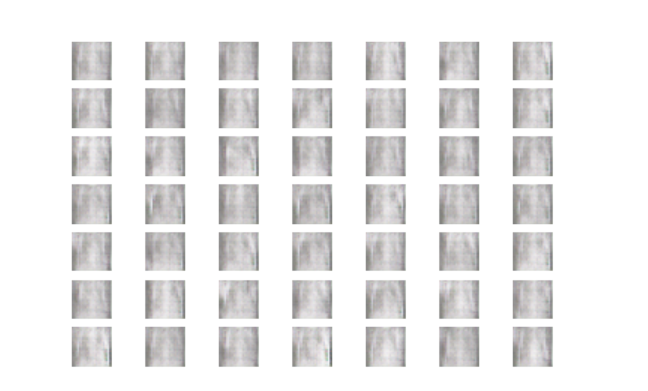

### Training Epoch = 200
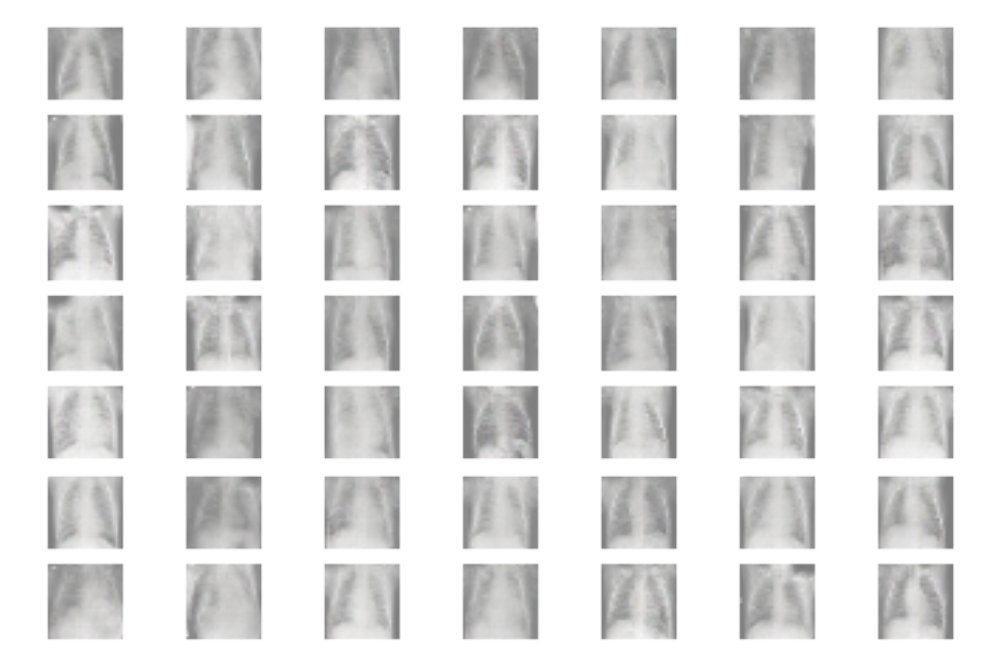

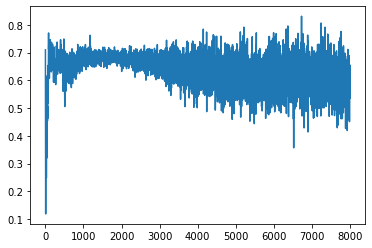

In [27]:
plt.plot(real_loss)

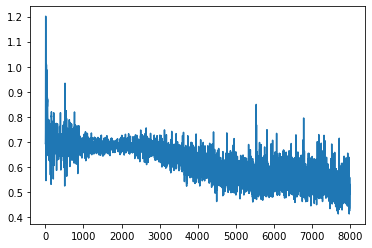

In [28]:
plt.plot(fake_loss)

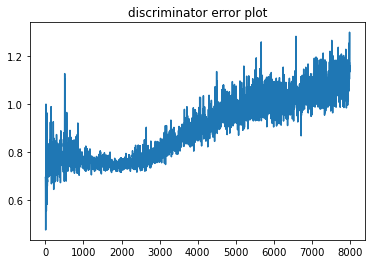

In [30]:
plt.title("discriminator error plot")
plt.plot(generator_loss)